# Experimenting with LSTM and indices...

I'm reading a datafile with all the REPSOL indices that we were computing using the 9th floor Spark processes. We will try to predict if the vlaue will go 'Up' or 'Down'.

In [12]:
import pandas
import matplotlib.pyplot as plt

file = '/Users/jrenero/Documents/SideProjects/X/indices_calculados_sinfecha.csv'
dataset = pandas.read_csv(file, engine='python', header='infer', delimiter=';', usecols=[0])
#dataset = dataset.drop('Unnamed: 2', axis=1)
dataset[:10]

,Price
0,15.935
1,15.760
2,15.735
3,15.990
4,15.725
5,15.955
6,16.000
7,15.800
8,15.380
9,15.450


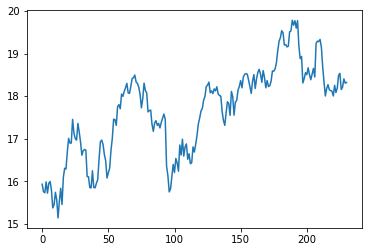

In [13]:
plt.plot(dataset)
plt.show()

## TensorFlow stuff.

In [14]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Let's make things reproducible. We also convert anything that might not be a float to `float32`. Data in NN is normalized to produce equivalent responses in the different layers. We also do that in this chunk.

In [16]:
numpy.random.seed(7)
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Split and reshape the dataset.

In [18]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:1], dataset[train_size:len(dataset),:1]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

154 77


In [19]:
trainX.shape, trainY.shape

((152, 1, 1), (152,))

Define the LSTM parameters, and train it.

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2)

Epoch 1/25
 - 1s - loss: 0.1268
Epoch 2/25
 - 1s - loss: 0.0392
Epoch 3/25
 - 1s - loss: 0.0198
Epoch 4/25
 - 1s - loss: 0.0169
Epoch 5/25
 - 1s - loss: 0.0149
Epoch 6/25
 - 1s - loss: 0.0128
Epoch 7/25
 - 1s - loss: 0.0108
Epoch 8/25
 - 1s - loss: 0.0089
Epoch 9/25
 - 1s - loss: 0.0073
Epoch 10/25
 - 1s - loss: 0.0060
Epoch 11/25
 - 1s - loss: 0.0050
Epoch 12/25
 - 1s - loss: 0.0042
Epoch 13/25
 - 1s - loss: 0.0038
Epoch 14/25
 - 1s - loss: 0.0035
Epoch 15/25
 - 1s - loss: 0.0033
Epoch 16/25
 - 1s - loss: 0.0033
Epoch 17/25
 - 1s - loss: 0.0032
Epoch 18/25
 - 1s - loss: 0.0032
Epoch 19/25
 - 1s - loss: 0.0032
Epoch 20/25
 - 1s - loss: 0.0032
Epoch 21/25
 - 1s - loss: 0.0032
Epoch 22/25
 - 1s - loss: 0.0032
Epoch 23/25
 - 1s - loss: 0.0032
Epoch 24/25
 - 1s - loss: 0.0032
Epoch 25/25
 - 1s - loss: 0.0032


Compute the error (RMSE) for training and test. Previously, the examples suggest to invert the results from prediction to use the same units than in the source data.

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.26 RMSE
Test Score: 0.22 RMSE


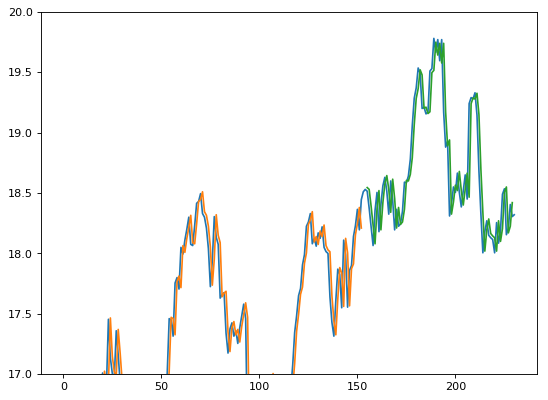

In [26]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylim((17,20))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()